In [ ]:
# if running on google colab, uncomment the next line and execute this cell to install the dependencies and prevent "ModuleNotFoundError" in later cells:
# !pip install pvdeg==0.3.3

In [12]:
import pvdeg
import os

In [ ]:
# This information helps with debugging and getting support :)
import sys, platform
print("Working on a ", platform.system(), platform.release())
print("Python version ", sys.version)
print("pvdeg version ", pvdeg.__version__)

## Adding Modules and Pipeline Jobs (Run Functions on Scenario Object)

In [2]:
scene_temp = pvdeg.scenario.Scenario(
    name= 'temperature and degradation',
    api_key='DEMO_KEY',
    email='user@mail.com',
)

scene_temp.addLocation(
    lat_long=(25.783388, -80.189029), 
    see_added=True,
)

# this module will be overwritten because another with the same name is added afterwards
scene_temp.addModule(
    module_name='sapm_1',
    temperature_model='sapm'
)

scene_temp.addModule(
    module_name='sapm_1',
    racking='open_rack_glass_polymer',
    material='EVA',
    temperature_model='sapm',
    irradiance_kwarg={'azimuth' : 120, 'tilt' : 30}, 
    model_kwarg={'irrad_ref' : 1100}, 
    see_added=True
)

scene_temp.addModule(
    module_name='pvsyst_1',
    racking='freestanding',
    material='EVA',
    temperature_model='pvsyst',
    irradiance_kwarg={'azimuth' : 180, 'tilt' : 0}, 
    model_kwarg={'module_efficiency' : 0.15}, 
    see_added=True
)
scene_temp.addModule(
    module_name='sapm_2',
    racking='open_rack_glass_polymer',
    material='EVA',
    temperature_model='sapm',
    irradiance_kwarg={'azimuth' : 120, 'tilt' : 30}, 
    model_kwarg={'irrad_ref' : 1000}, 
    see_added=True
)
scene_temp.addModule(
    module_name='sapm_3',
    racking='open_rack_glass_polymer',
    material='EVA',
    temperature_model='sapm',
    irradiance_kwarg={'azimuth' : 180, 'tilt' : 0}, 
    model_kwarg={'irrad_ref' : 1000}, 
    see_added=True
)

scene_temp.addModule(
    module_name='pvsyst_2',
    racking='freestanding',
    material='EVA',
    temperature_model='pvsyst',
    irradiance_kwarg={'azimuth' : 180, 'tilt' : 0}, 
    model_kwarg={'module_efficiency' : 0.2}, 
    see_added=True
)

scene_temp.addJob(
    func=pvdeg.temperature.temperature,
    func_kwarg={'cell_or_mod' : 'cell'}, 
    see_added=True
)

scene_temp.addJob(
    func=pvdeg.degradation.vantHoff_deg,
    func_kwarg={'I_chamber' : 1000, 'temp_chamber' : 25},
    see_added=True
)

scene_temp.addJob(
    func=pvdeg.degradation.vantHoff_deg,
    func_kwarg={'I_chamber' : 1000, 'temp_chamber' : 30},
    see_added=True
)

scene_temp.addJob(
    func=pvdeg.degradation.IwaVantHoff,
    see_added=True
)

Column "relative_humidity" not found in DataFrame. Calculating...
WARNING - Module already found by name "sapm_1"
Module will be replaced with new instance.
Module "sapm_1" added.
Module "pvsyst_1" added.
Module "sapm_2" added.
Module "sapm_3" added.
Module "pvsyst_2" added.


C:\Users\tford\dev\PVDegradationTools\pvdeg\scenario.py:236: UserWarning: Gids Added - [1060699]
  warnings.warn(message, UserWarning)
C:\Users\tford\dev\PVDegradationTools\pvdeg\scenario.py:399: UserWarning: temperature added to pipeline as 
 {'job': <function temperature at 0x00000230D016CD30>, 'params': {'cell_or_mod': 'cell'}}
  warnings.warn(message, UserWarning)
C:\Users\tford\dev\PVDegradationTools\pvdeg\scenario.py:399: UserWarning: vantHoff_deg added to pipeline as 
 {'job': <function vantHoff_deg at 0x00000230D12E4160>, 'params': {'I_chamber': 1000, 'temp_chamber': 25}}
  warnings.warn(message, UserWarning)
C:\Users\tford\dev\PVDegradationTools\pvdeg\scenario.py:399: UserWarning: vantHoff_deg added to pipeline as 
 {'job': <function vantHoff_deg at 0x00000230D12E4160>, 'params': {'I_chamber': 1000, 'temp_chamber': 30}}
  warnings.warn(message, UserWarning)
C:\Users\tford\dev\PVDegradationTools\pvdeg\scenario.py:399: UserWarning: IwaVantHoff added to pipeline as 
 {'job': <fun

## Run and View Scenario Results

In [3]:
scene_temp.run()

scene_temp

,0
2005-01-01 00:30:00-05:00,22.000000
2005-01-01 01:30:00-05:00,21.000000
2005-01-01 02:30:00-05:00,21.000000
2005-01-01 03:30:00-05:00,21.000000
2005-01-01 04:30:00-05:00,21.000000
2005-01-01 05:30:00-05:00,21.000000
2005-01-01 06:30:00-05:00,21.000000
2005-01-01 07:30:00-05:00,22.035591
2005-01-01 08:30:00-05:00,28.016994
2005-01-01 09:30:00-05:00,32.514264


In [4]:
scene_temp.dump()

## Plotting and Extracting Results
These methods are independent of one another (i.e. you do not need to extract before plotting but both are shown below.)

In [7]:
import datetime
t0=datetime.datetime(1970,1,1,0,0) 
tf=datetime.datetime(1970,1,1,23,59)

# search by funciton id which is random and changes every time
# must update here, look at the purple ids in the display function above
temp_df = scene_temp.extract(('function', 'HKXVD'),tmy=True,start_time=t0,end_time=tf) 

display(temp_df)

,sapm_1,pvsyst_1,sapm_2,sapm_3,pvsyst_2
1970-01-01 00:30:00-05:00,22.000000,22.000000,22.000000,22.000000,22.000000
1970-01-01 01:30:00-05:00,21.000000,21.000000,21.000000,21.000000,21.000000
1970-01-01 02:30:00-05:00,21.000000,21.000000,21.000000,21.000000,21.000000
1970-01-01 03:30:00-05:00,21.000000,21.000000,21.000000,21.000000,21.000000
1970-01-01 04:30:00-05:00,21.000000,21.000000,21.000000,21.000000,21.000000
1970-01-01 05:30:00-05:00,21.000000,21.000000,21.000000,21.000000,21.000000
1970-01-01 06:30:00-05:00,21.000000,21.000000,21.000000,21.000000,21.000000
1970-01-01 07:30:00-05:00,23.643151,22.035591,23.681606,21.746611,21.974674
1970-01-01 08:30:00-05:00,31.292408,28.016994,31.430577,26.245927,27.663053
1970-01-01 09:30:00-05:00,34.146799,32.514264,34.331368,29.262679,31.895778


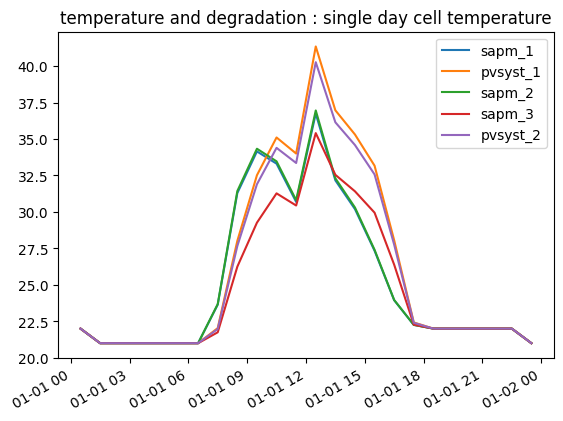

In [8]:
scene_temp.plot(('function', 'HKXVD'),tmy=True,start_time=t0,end_time=tf,title='single day cell temperature')

## Create a Copy of a Scenario

In [25]:
from pathlib import Path

parent_dir = Path(pvdeg.PVDEG_DIR).parent
new_path = os.path.join(parent_dir, r'tutorials_and_tools\tutorials_and_tools\temperature and degradation.json')

copy = pvdeg.scenario.Scenario.load_json(
    file_path=new_path,
    email='user@mail.com',
    api_key='DEMO_KEY',
)

copy

credentials not in json file using arguments
Column "relative_humidity" not found in DataFrame. Calculating...


,Year,Month,Day,Hour,Minute,dew_point,dhi,dni,ghi,albedo,pressure,temp_air,wind_direction,wind_speed,relative_humidity
0,2005,1,1,0,30,17.0,0.0,0.0,0.0,0.1,1020.0,22.0,94.0,6.4,73.288965
1,2005,1,1,1,30,17.0,0.0,0.0,0.0,0.1,1020.0,21.0,93.0,6.1,77.915158
2,2005,1,1,2,30,17.0,0.0,0.0,0.0,0.1,1020.0,21.0,92.0,5.9,77.915158
3,2005,1,1,3,30,17.0,0.0,0.0,0.0,0.1,1020.0,21.0,91.0,5.6,77.915158
4,2005,1,1,4,30,16.0,0.0,0.0,0.0,0.1,1020.0,21.0,89.0,5.1,73.11466
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8755,1999,12,31,19,30,18.0,0.0,0.0,0.0,0.1,1020.0,22.0,86.0,5.9,78.062864
8756,1999,12,31,20,30,18.0,0.0,0.0,0.0,0.1,1020.0,22.0,88.0,5.9,78.062864
8757,1999,12,31,21,30,18.0,0.0,0.0,0.0,0.1,1020.0,22.0,90.0,6.0,78.062864
8758,1999,12,31,22,30,18.0,0.0,0.0,0.0,0.1,1020.0,22.0,92.0,6.2,78.062864
